In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset
### Data generate

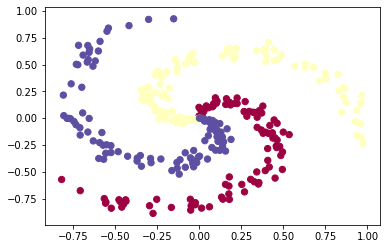

(300, 2)
(300, 3)


In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
inputs = np.zeros((N*K,D)) # data matrix (each row = single example)
targets = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    inputs[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    targets[ix] = j

# # lets visualize the data:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets, s=40, cmap=plt.cm.Spectral)
plt.show()

one_hot = np.zeros([N*K ,K], dtype=np.int)
for i in range(len(targets)):
    one_hot[i][targets[i]] = 1 
targets = one_hot

print (inputs.shape)
print (targets.shape)

### Shuffling dataset

In [3]:
shuffle_indices = np.arange(len(inputs))
np.random.shuffle(shuffle_indices)

inputs = inputs[shuffle_indices]
targets = targets[shuffle_indices]

### Split the dataset

In [4]:
training_rate = .9

sample_count = len(inputs)
train_sample_count = int(training_rate * sample_count)

train_inputs  = inputs[0:train_sample_count]
train_targets = targets[0:train_sample_count]

test_inputs  = inputs[train_sample_count::]
test_targets = targets[train_sample_count::]

print(train_inputs.shape)
print(train_targets.shape)
print(test_inputs.shape)
print(test_targets.shape)

(270, 2)
(270, 3)
(30, 2)
(30, 3)


# Model

### Architecture :

In [5]:
inputs_units = 2
hidden_units = 100
outputs_units = 3

### Initialization :

In [9]:
np.random.seed(1)
W1 = np.random.uniform(-1, 1, size=(inputs_units ,hidden_units))
dW1_m = np.zeros((inputs_units ,hidden_units))
dW1_v = np.zeros((inputs_units ,hidden_units))
dW1_m_hat = np.zeros((inputs_units ,hidden_units))
dW1_v_hat = np.zeros((inputs_units ,hidden_units))

W2 = np.random.uniform(-1, 1, size=(hidden_units ,outputs_units))
dW2_m = np.zeros((hidden_units ,outputs_units))
dW2_v = np.zeros((hidden_units ,outputs_units))
dW2_m_hat = np.zeros((hidden_units ,outputs_units))
dW2_v_hat = np.zeros((hidden_units ,outputs_units))

b1 = np.random.uniform(-1, 1, size=(1, hidden_units))
db1_m = np.zeros((1 ,hidden_units))
db1_v = np.zeros((1 ,hidden_units))
db1_m_hat = np.zeros((1 ,hidden_units))
db1_v_hat = np.zeros((1 ,hidden_units))

b2 = np.random.uniform(-1, 1, size=(1, outputs_units))
db2_m = np.zeros((1, outputs_units))
db2_v = np.zeros((1, outputs_units))
db2_m_hat = np.zeros((1, outputs_units))
db2_v_hat = np.zeros((1, outputs_units))

### Train Model :

In [10]:
epochs = 100
batch_size = 5
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

num_examples = train_inputs.shape[0]

for epoch in range(epochs):
    iter_loss = 0.
    iter_accuracy = 0.
    iteration = 0
    for batch_index in range(0, num_examples, batch_size):
        iteration += 1
        if (batch_index + batch_size) > num_examples:
            X = train_inputs[batch_index::]
            y = train_targets[batch_index::]
        else:
            X = train_inputs[batch_index:batch_index + batch_size]
            y = train_targets[batch_index:batch_index + batch_size]
        
        hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(hidden_layer, W2) + b2

        normalize_scores = scores - scores.max()
        exp_scores = np.exp(normalize_scores)
        y_hat = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        loss = -np.sum(y * np.log(y_hat)) / batch_size
        iter_loss += loss
        
        d_loss = y_hat - y
        d_loss /= batch_size 

        dW2 = np.dot(hidden_layer.T, d_loss)
        dW2_m = beta1 * dW2_m + (1-beta1) * dW2
        dW2_v = beta2 * dW2_v + (1-beta2) * np.power(dW2, 2)
        dW2_m_hat = dW2_m / (1- np.power(beta1, epoch+1))
        dW2_v_hat = dW2_v / (1- np.power(beta2, epoch+1))
        
        db2 = np.sum(d_loss, axis=0, keepdims=True)
        db2_m = beta1 * db2_m + (1-beta1) * db2
        db2_v = beta2 * db2_v + (1-beta2) * np.power(db2, 2)
        db2_m_hat = db2_m / (1- np.power(beta1, epoch+1))
        db2_v_hat = db2_v / (1- np.power(beta2, epoch+1))
                             
        dhidden = np.dot(d_loss, W2.T)
        dhidden[hidden_layer <= 0] = 0
        
        dW1 = np.dot(X.T, dhidden)
        dW1_m = beta1 * dW1_m + (1-beta1) * dW1
        dW1_v = beta2 * dW1_v + (1-beta2) * np.power(dW1, 2)
        dW1_m_hat = dW1_m / (1- np.power(beta1, epoch+1))
        dW1_v_hat = dW1_v / (1- np.power(beta2, epoch+1))
        
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        db1_m = beta1 * db1_m + (1-beta1) * db1
        db1_v = beta2 * db1_v + (1-beta2) * np.power(db1, 2)
        db1_m_hat = db1_m / (1- np.power(beta1, epoch+1))
        db1_v_hat = db1_v / (1- np.power(beta2, epoch+1))
        
       
        W1 += -learning_rate * dW1_m_hat / (np.sqrt(dW1_v_hat) + epsilon)
        b1 += -learning_rate * db1_m_hat / (np.sqrt(db1_v_hat) + epsilon)
        W2 += -learning_rate * dW2_m_hat / (np.sqrt(dW2_v_hat) + epsilon)
        b2 += -learning_rate * db2_m_hat / (np.sqrt(db2_v_hat) + epsilon)

        accuracy = (np.argmax(y, axis=1) == np.argmax(y_hat, axis=1)).mean()
        iter_accuracy += accuracy
        
    iter_loss /= iteration
    iter_accuracy /= iteration
    
    if epoch % 10 ==0:
        print('Epoch [{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch, iter_loss, 100*iter_accuracy))

Epoch [0], Loss: 0.7695, Accuracy: 62.6%
Epoch [10], Loss: 0.2244, Accuracy: 93.7%
Epoch [20], Loss: 0.1611, Accuracy: 96.7%
Epoch [30], Loss: 0.1234, Accuracy: 98.1%
Epoch [40], Loss: 0.0984, Accuracy: 98.9%
Epoch [50], Loss: 0.0805, Accuracy: 98.9%
Epoch [60], Loss: 0.0669, Accuracy: 98.9%
Epoch [70], Loss: 0.0569, Accuracy: 98.9%
Epoch [80], Loss: 0.0492, Accuracy: 98.9%
Epoch [90], Loss: 0.0433, Accuracy: 99.3%


### Test Model :

In [11]:
X = test_inputs
y = test_targets

num_examples = len(y)

hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2

normalize_scores = scores - scores.max()
exp_scores = np.exp(normalize_scores)
y_hat = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

loss = -np.sum(y * np.log(y_hat)) / num_examples
accuracy = (np.argmax(y, axis=1) == np.argmax(y_hat, axis=1)).mean()

print('Loss: {:.4f}, Accuracy: {:.1f}%'.format(loss, 100*accuracy))

Loss: 0.0372, Accuracy: 100.0%
